In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

# Data Preprocessing

In [3]:
# Data source
# run on google colab
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()



--2021-02-19 06:32:16--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.101.128, 2607:f8b0:4023:c03::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-02-19 06:32:16 (122 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [4]:
import re
corpus = data.lower()
corpus = re.split(r"([\n,!?;.\s+])", corpus)
while ' ' in corpus:
  corpus.remove(' ')
while '' in corpus:
  corpus.remove('')

In [5]:
print(corpus)

['from', 'fairest', 'creatures', 'we', 'desire', 'increase', ',', '\n', 'that', 'thereby', "beauty's", 'rose', 'might', 'never', 'die', ',', '\n', 'but', 'as', 'the', 'riper', 'should', 'by', 'time', 'decease', ',', '\n', 'his', 'tender', 'heir', 'might', 'bear', 'his', 'memory:', '\n', 'but', 'thou', ',', 'contracted', 'to', 'thine', 'own', 'bright', 'eyes', ',', '\n', "feed'st", 'thy', "light'st", 'flame', 'with', 'self-substantial', 'fuel', ',', '\n', 'making', 'a', 'famine', 'where', 'abundance', 'lies', ',', '\n', 'thyself', 'thy', 'foe', ',', 'to', 'thy', 'sweet', 'self', 'too', 'cruel', '.', '\n', 'thou', 'that', 'art', 'now', 'the', "world's", 'fresh', 'ornament', '\n', 'and', 'only', 'herald', 'to', 'the', 'gaudy', 'spring', ',', '\n', 'within', 'thine', 'own', 'bud', 'buriest', 'thy', 'content', '\n', 'and', ',', 'tender', 'churl', ',', 'makest', 'waste', 'in', 'niggarding', '.', '\n', 'pity', 'the', 'world', ',', 'or', 'else', 'this', 'glutton', 'be', ',', '\n', 'to', 'eat',

In [6]:
# delete extra blank lines
del corpus[2380:2385]

In [7]:
# delete Sonnet 99 since it has 15 rows
del corpus[13985:14141]

In [8]:
# delete Sonnet 126 since it has 12 rows
del corpus[17705:17834]

In [9]:
corpus.count('\n')/14

152.0

In [10]:
len(corpus)

21836

In [11]:
len(set(corpus))

3330

# Feature and Label

Tokenizer will encode words to integers by tf-idf. <br>
For unseen words in val/test data, it will just ignore them.

In [39]:
tokenizer = Tokenizer(filters = [])
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [40]:
print(total_words)

3331


In [14]:
tokenizer.texts_to_sequences(["\n"])

[[1]]

In [15]:
tokenizer.texts_to_sequences(["UNSEEN_WORD"])

[[]]

In [16]:
input_sequences = tokenizer.texts_to_sequences(corpus)
input_sequences = list(sum(input_sequences,[]))

Use every 10 words to as features predict the next one. <br>
Be careful about the gap between two poems. (Using count_row to keep track)

In [17]:
features = []
labels = []
count_row = 0
predict_n = 10
i = 0
while(i < len(input_sequences)):
  if i >= predict_n:
    features.append(input_sequences[i-predict_n:i])
    labels.append([input_sequences[i]])
  if input_sequences[i] == 1:
    count_row += 1
    if count_row >= 14:
      count_row = 0
      i += predict_n+1
    else:
      i += 1
  else:
    i += 1

In [18]:
labels=np.array(labels)
features=np.array(features)

Shuffle

In [26]:
features.shape

(20366, 10)

In [23]:
labels.shape

(20366, 1)

In [27]:
comb = np.hstack([features, labels])
comb[:5]

array([[ 39, 409, 858, 161, 208, 612,   2,   1,  11, 859, 134],
       [409, 858, 161, 208, 612,   2,   1,  11, 859, 134, 347],
       [858, 161, 208, 612,   2,   1,  11, 859, 134, 347, 107],
       [161, 208, 612,   2,   1,  11, 859, 134, 347, 107, 162],
       [208, 612,   2,   1,  11, 859, 134, 347, 107, 162, 209]])

In [28]:
np.random.shuffle(comb)

In [29]:
comb[:5]

array([[1088,   11,   16,  115,    2,    1,    3, 2943,   70,  141,  342],
       [  11,  931,    4,  601,    6,   13,  152,    2,    1,  197, 1095],
       [   2,    1,   30,  209,   17, 1311,    2,  100,   44,  592,   17],
       [ 119,   14,  827,    5,    8,  125, 3037,   61,    1,   14,   58],
       [  11,   86,   16,  136,    6,  122,    1,    9,   38,  537,   65]])

In [30]:
features = comb[:,:10]
labels = comb[:,-1]

In [33]:
len(labels)

20366

One-hot encode labels to binary vectors.

In [34]:
label_cat = ku.to_categorical(labels, num_classes=total_words)

In [35]:
label_cat.shape

(20366, 3331)

In [37]:
label_cat[0][342]

1.0

# Build the model

In [41]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length = predict_n))
model.add(LSTM(150, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
model.add(Dense(total_words, activation = 'softmax'))
# Pick an optimizer
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 100)           333100    
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 150)           150600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 150)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               100400    
_________________________________________________________________
dense_2 (Dense)              (None, 1665)              168165    
_________________________________________________________________
dense_3 (Dense)              (None, 3331)              5549446   
Total params: 6,301,711
Trainable params: 6,301,711
Non-trainable params: 0
____________________________________________

# Train the model

In [45]:
history = model.fit(features, label_cat, epochs=50, validation_split=0.2, verbose=1)

Epoch 1/50
510/510 [==============================] - 46s 91ms/step - loss: 4.5799 - accuracy: 0.1991 - val_loss: 6.5440 - val_accuracy: 0.1443
Epoch 2/50
510/510 [==============================] - 46s 90ms/step - loss: 4.4968 - accuracy: 0.2048 - val_loss: 6.6918 - val_accuracy: 0.1502
Epoch 3/50
510/510 [==============================] - 46s 90ms/step - loss: 4.4133 - accuracy: 0.2072 - val_loss: 6.9199 - val_accuracy: 0.1483
Epoch 4/50
510/510 [==============================] - 46s 91ms/step - loss: 4.3277 - accuracy: 0.2158 - val_loss: 6.9932 - val_accuracy: 0.1480
Epoch 5/50
510/510 [==============================] - 46s 91ms/step - loss: 4.2516 - accuracy: 0.2213 - val_loss: 7.2752 - val_accuracy: 0.1502
Epoch 6/50
510/510 [==============================] - 46s 91ms/step - loss: 4.1661 - accuracy: 0.2296 - val_loss: 7.2364 - val_accuracy: 0.1453
Epoch 7/50
510/510 [==============================] - 46s 91ms/step - loss: 4.0852 - accuracy: 0.2401 - val_loss: 7.5553 - val_accuracy:

# Plot

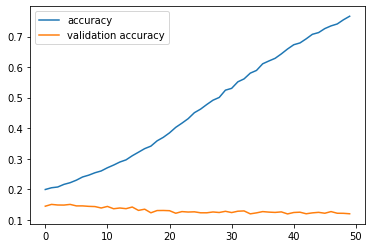

In [46]:
# plot the model accuracy and validation accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','validation accuracy'])

This is actually not a good model - due to lack of data.
（But we still go with it here to demo the idea.)

# Generate new Sonnet with given start line

In [83]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope \n"

Pre-processing

In [84]:
seed = re.split(r"([\n,!?;.\s+])", seed_text.lower())
while ' ' in seed:
  seed.remove(' ')
while '' in seed:
  seed.remove('')
seed

['help',
 'me',
 'obi',
 'wan',
 'kenobi',
 ',',
 "you're",
 'my',
 'only',
 'hope',
 '\n']

Predict next word, rolling forward till reaching 14 rows

In [85]:
count_row = 0
while(count_row <= 13):
  token_list = tokenizer.texts_to_sequences([seed])[0]
  token_list = pad_sequences([token_list], maxlen=predict_n, padding='pre')
  predicted = np.argmax(model.predict(token_list), axis=-1)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      seed.append(output_word)
      seed_text += " " + output_word
      if predicted == 1:
        count_row += 1

print(seed_text)     

Help me Obi Wan Kenobi, you're my only hope 
 all hear , are they , are many , to those 
 as nights they rich her ground ; 
 thou gavest my youth and you with thee ? 
 alas of this part , love in one 
 are objects of this honey hours ; 
 for purest and wrinkles out , 
 although left thy charge age , 
 which almost gaze fresh such that but see aside: 
 since at the willing kindness mayst the prophetic away , 
 for borrow'd others' at their bastard and after-loss: 
 so makest love-kindling leaves ; 
 but there are fell thing in base on thee , 
 the beauty why lends which you weak with cross , 
 thou art in this one world was goes eyes , 

